In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import pickle

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
df = pd.read_csv("NHANES_age_prediction.csv")

# EDA

Рассмотрим датасет: проверим пропуски в данных, константные параметры, посмотрим на их распределение.

Описание параметров:

![features](images/features.png)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB


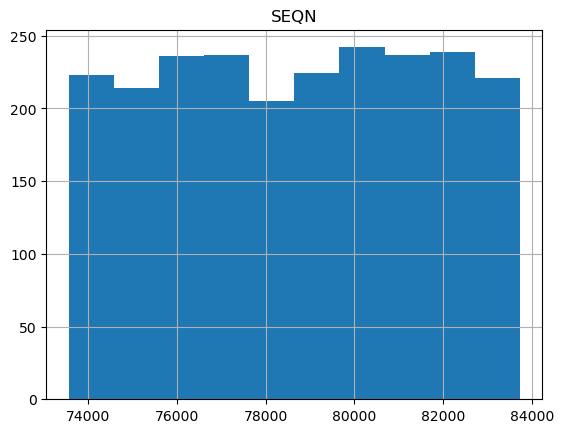

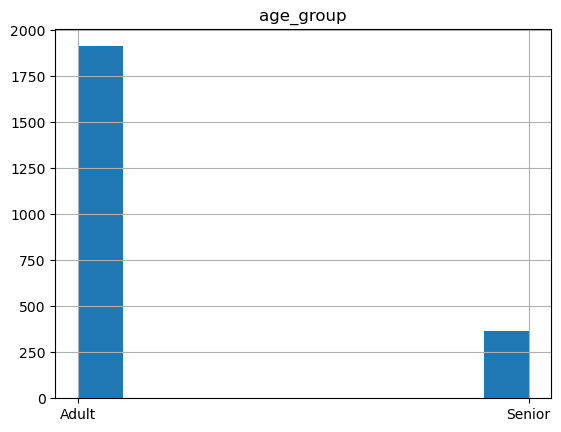

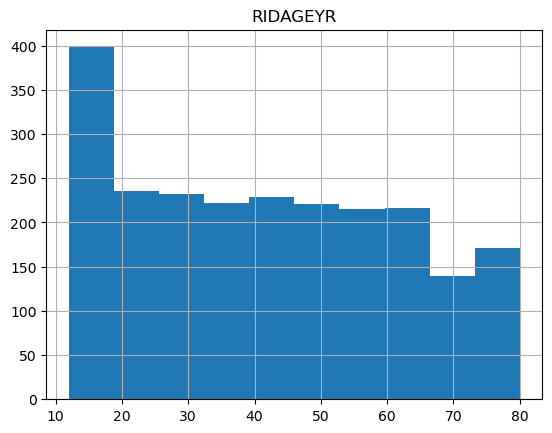

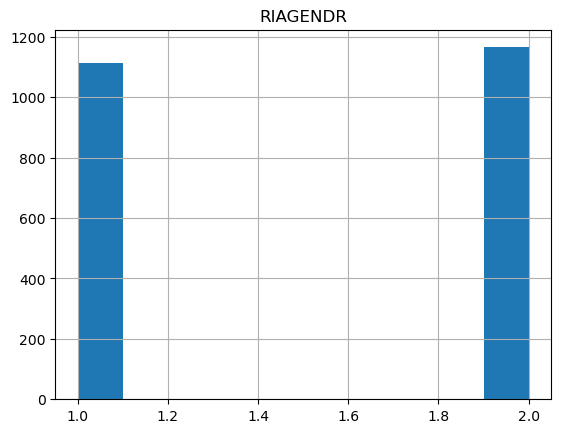

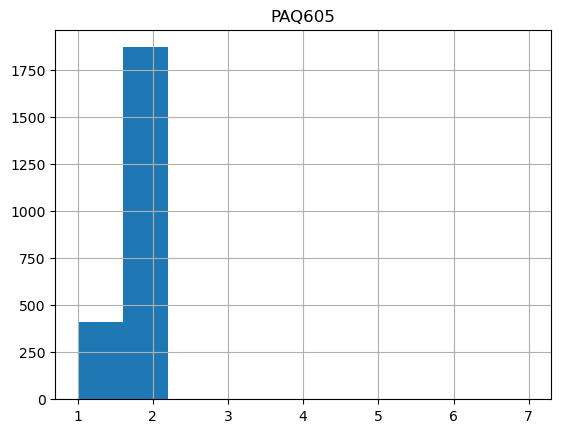

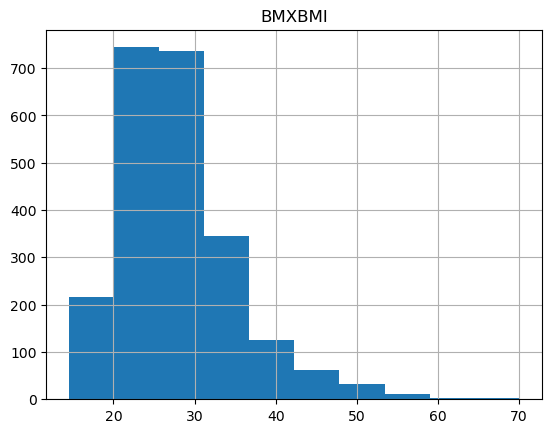

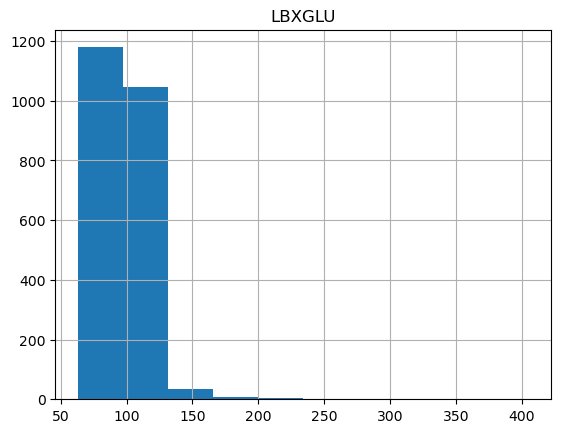

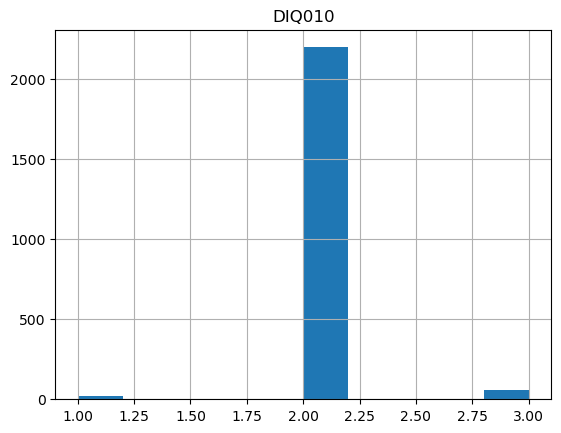

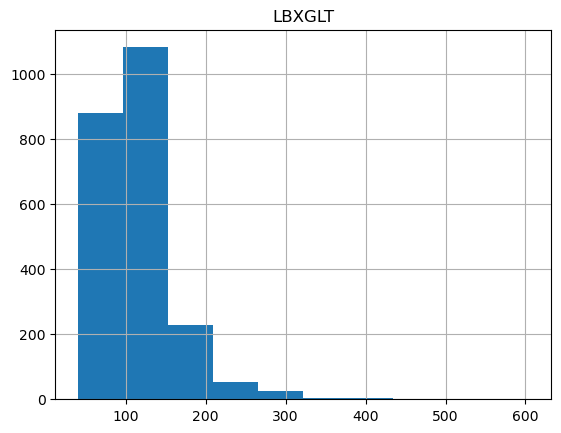

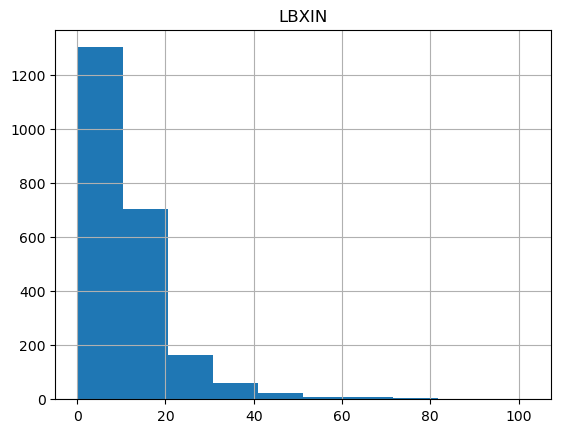

In [6]:
for col in df.columns:
    df[col].hist()
    plt.title(col)
    plt.show()

## EDA результаты

Пропусков в датасете нет, все признаки предварительно кажутся полезными для задачи.

Для улучшения семантики задачи, я решил дополнительно разделить классы на возрастные периоды ([wiki](https://ru.wikipedia.org/wiki/%D0%92%D0%BE%D0%B7%D1%80%D0%B0%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)).
Периоды изменил с учетом существующих данных:

Юношеский период: 12—21 год (young)

Зрелый возраст (1-й период): 21—35 лет (adult1)

Зрелый возраст (2-й период): 35—60 лет (adult2)

Пожилой возраст: 60—80 лет (senior)


In [7]:
df = df.drop(columns="age_group", errors="ignore")

In [8]:
df.loc[(12 <= df['RIDAGEYR']) & (df['RIDAGEYR'] < 21), 'age_group'] = 'young'
df.loc[(21 <= df['RIDAGEYR']) & (df['RIDAGEYR'] < 35), 'age_group'] = 'adult1'
df.loc[(35 <= df['RIDAGEYR']) & (df['RIDAGEYR'] < 60), 'age_group'] = 'adult2'
df.loc[(60 <= df['RIDAGEYR']) & (df['RIDAGEYR'] <= 80), 'age_group'] = 'senior'

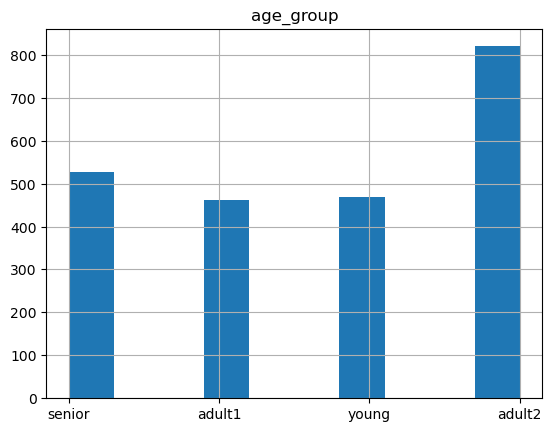

In [9]:
df.age_group.hist()
plt.title('age_group')
plt.show()

# Подготовка ML моделей

Решил использовать модель случайного леса из sklearn, XGBoost и CatBoost.

In [10]:
def show_metrics(model, X_test, y_test, X_train, y_train):
    print(f"Train accuracy: {model.score(X_train, y_train)}")
    print(f"Test accuracy: {model.score(X_test, y_test)}")
    print(f"Test report: {classification_report(y_test, model.predict(X_test))}")
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
X = df.drop(columns=['age_group'])
y = df.age_group

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
X_train.drop(columns='RIDAGEYR', inplace=True)
test_ages = X_test['RIDAGEYR']
X_test.drop(columns='RIDAGEYR', inplace=True)

In [15]:
clf = RandomForestClassifier(max_depth=10, n_estimators=25, class_weight='balanced', random_state=4)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=25,
                       random_state=4)

Train accuracy: 0.8611416026344676
Test accuracy: 0.48026315789473684
Test report:               precision    recall  f1-score   support

      adult1       0.31      0.23      0.26        93
      adult2       0.50      0.54      0.52       164
      senior       0.47      0.46      0.46       105
       young       0.56      0.66      0.60        94

    accuracy                           0.48       456
   macro avg       0.46      0.47      0.46       456
weighted avg       0.47      0.48      0.47       456



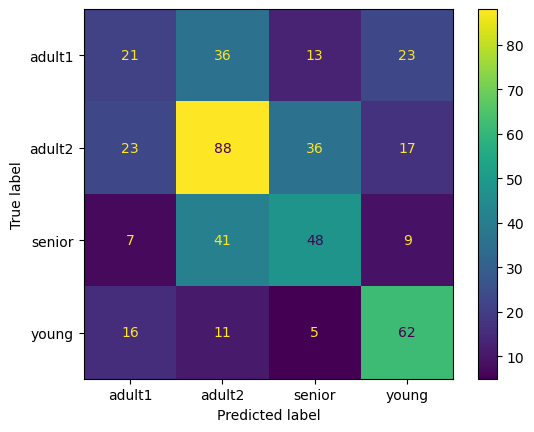

In [16]:
show_metrics(clf, X_test, y_test, X_train, y_train)

In [17]:
with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [18]:
from xgboost import XGBClassifier

In [19]:
from sklearn.utils.class_weight import compute_class_weight

In [20]:
bst = XGBClassifier(n_estimators=10, max_depth=5, learning_rate=0.01, objective='multi:softmax')
bst.fit(X_train, y_train)

[13:55:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Train accuracy: 0.5762897914379802
Test accuracy: 0.48903508771929827
Test report:               precision    recall  f1-score   support

      adult1       0.33      0.11      0.16        93
      adult2       0.46      0.71      0.56       164
      senior       0.49      0.35      0.41       105
       young       0.61      0.64      0.62        94

    accuracy                           0.49       456
   macro avg       0.47      0.45      0.44       456
weighted avg       0.47      0.49      0.46       456



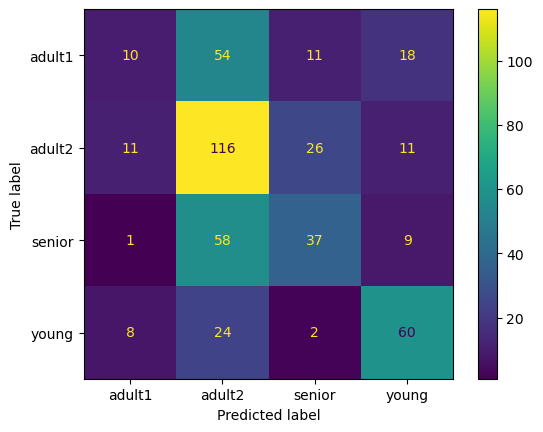

In [21]:
show_metrics(bst, X_test, y_test, X_train, y_train)

In [22]:
bst.save_model('bst.json')

In [23]:
from catboost import CatBoostClassifier

In [24]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )

In [25]:
catbst = CatBoostClassifier(iterations=100,
                           depth=10,
                           learning_rate=0.1,
                           loss_function='MultiClass',
                           class_weights=class_weights,
                           verbose=True)

In [26]:
catbst.fit(X_train, y_train)

0:	learn: 1.3623099	total: 189ms	remaining: 18.7s
1:	learn: 1.3380325	total: 227ms	remaining: 11.1s
2:	learn: 1.3142109	total: 288ms	remaining: 9.33s
3:	learn: 1.2906284	total: 353ms	remaining: 8.47s
4:	learn: 1.2718043	total: 421ms	remaining: 7.99s
5:	learn: 1.2500630	total: 488ms	remaining: 7.65s
6:	learn: 1.2309330	total: 561ms	remaining: 7.46s
7:	learn: 1.2128806	total: 632ms	remaining: 7.27s
8:	learn: 1.1975416	total: 701ms	remaining: 7.08s
9:	learn: 1.1818563	total: 771ms	remaining: 6.93s
10:	learn: 1.1664843	total: 839ms	remaining: 6.79s
11:	learn: 1.1615873	total: 844ms	remaining: 6.19s
12:	learn: 1.1461770	total: 908ms	remaining: 6.08s
13:	learn: 1.1302256	total: 976ms	remaining: 6s
14:	learn: 1.1170465	total: 1.04s	remaining: 5.91s
15:	learn: 1.1068863	total: 1.11s	remaining: 5.84s
16:	learn: 1.0945506	total: 1.19s	remaining: 5.8s
17:	learn: 1.0851552	total: 1.28s	remaining: 5.81s
18:	learn: 1.0745800	total: 1.36s	remaining: 5.8s
19:	learn: 1.0645505	total: 1.43s	remaining: 5

Train accuracy: 0.8304061470911087
Test accuracy: 0.48464912280701755
Test report:               precision    recall  f1-score   support

      adult1       0.34      0.30      0.32        93
      adult2       0.54      0.45      0.49       164
      senior       0.48      0.52      0.50       105
       young       0.52      0.68      0.59        94

    accuracy                           0.48       456
   macro avg       0.47      0.49      0.48       456
weighted avg       0.48      0.48      0.48       456



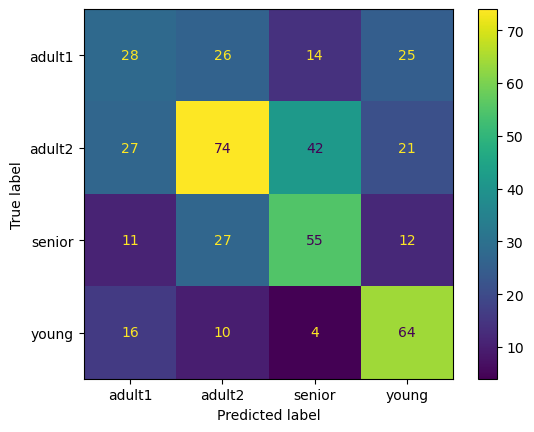

In [27]:
show_metrics(catbst, X_test, y_test, X_train, y_train)

In [28]:
catbst.save_model('catbst.json', format="json")

## ML results
Все три модели показывают примерно одинаковый результат, поэтому ранжировать их по качеству невозможно.

Остается вариант распределения моделей по скорости - чем быстрее тем дороже или наоборот в зависимости от идеи оплаты - за скорость или за "ресурсы".

In [29]:
sample = X_test.iloc[0].values.reshape(1, -1)

In [30]:
%timeit clf.predict(sample)

2.07 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%timeit bst.predict(sample)

5.37 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%timeit catbst.predict(sample)

594 µs ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
